In [66]:
import numpy as np
print("numpy version: {}".format(np.__version__))
import matplotlib.pyplot as plt
%matplotlib inline

numpy version: 1.19.5


In [188]:
class groundTruth():
    def __init__(self, output_noise_std=0.1, 
                 num_train_data=7):
        # magnitude of output noise
        self.output_noise_std = output_noise_std
        # number of train data   
        self.num_train_data = num_train_data 
        # input domain
        self.domain_grid = np.linspace(0.0, 7.0, 1000)
        # sample train data
        self.input_train = self.generate_input_train(size=self.num_train_data)
        # sample output noise
        self.output_noise = self.generate_noise(self.input_train)

    def generate_input_train(self, size):
        return np.random.uniform(0.0, 7.0, size=size)

    def generate_ground_truth(self, x):
        ground_truth = self.f(x)
        return ground_truth

    def generate_noise(self, x):
        return np.random.normal(loc=0, scale=self.output_noise_std, size=x.size)

    def generate_output(self, x):
        ground_truth = self.generate_ground_truth(x)
        output_train = ground_truth + self.output_noise
        return output_train

    def plot_ground_truth(self):
        plt.plot(self.domain_grid, self.f(self.domain_grid), 'r', label=r'Ground Truth')
        plt.plot(self.input_train, self.generate_output(self.input_train), 'b.', marker="+", markersize=12, label='Observations')
        plt.xlabel('$x$')
        plt.ylabel('$f(x)$')
        plt.ylim(-2, 2)
        plt.legend(loc='upper right')

    def f(self, x): # target function
        return x * np.sin(x) * np.exp(-x)

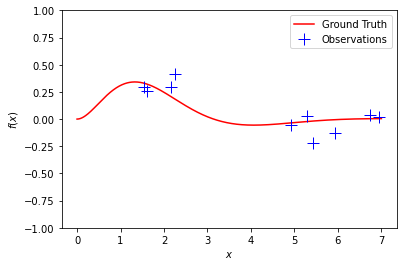

In [189]:
gt = groundTruth(num_train_data=10)
gt.plot_ground_truth()
plt.ylim(-1, 1)
plt.show()

In [199]:
class gaussianProcess():
    def __init__(self, ground_truth):
        self.ground_truth=ground_truth
        self.K = self.compute_covariance_matrix(self.ground_truth.input_train, 
                                                self.ground_truth.input_train, 
                                                True)
        self.K_inverse = self.inverse_covariance_matrix(self.K)

    def compute_kernel(self, x1, x2, sigma_f=1.0, length=1.0):
        """
        squared-exponential covariance function
        k(x1, x2) = sigma_f**2 * exp(-(x1 - x2)**2 / 2*(length**2))
        """
        distance = np.power(x1 - x2, 2)
        distance /= 2 * (length ** 2)
        output = (sigma_f ** 2) * np.exp(-distance)
        return output
#-------------------------------(HOMEWORK-START)------------------------------#        
    def inverse_covariance_matrix(self, K):
        """Homework: DO NOT USE THIS CODE. Implement Cholesky Decomposition."""
        """HINT: USE numpy.linalg.cholesky"""
        K_inverse = np.linalg.cholesky(K)
        return K_inverse

    def compute_alpha(self, y):
        """Homework: MODIFY THE CODE BELOW"""
        m = np.linalg.solve(self.K_inverse, y)
        return np.linalg.solve(self.K_inverse.T, m)
    
    def compute_mean(self, kernel, y):
        mean = np.dot(np.transpose(kernel), self.compute_alpha(y)).squeeze()
        return mean

    def compute_cov(self, kernel, x):
        """Homework: MODIFY THE CODE BELOW"""
        beta = np.linalg.solve(self.K, kernel)
        cov = self.compute_kernel(x, x) - kernel.T @ beta
        return cov
#-------------------------------(HOMEWORK-END)-------------------------------#        
    def compute_mean_cov(self, x_test):
        K_test = np.array([self.compute_kernel(x_test, x_) for x_ in self.ground_truth.input_train])
        y = self.ground_truth.generate_output(self.ground_truth.input_train)
        predict_mean = self.compute_mean(kernel=K_test, y=y)
        predict_cov = self.compute_cov(kernel=K_test, x=x_test)
        return predict_mean, predict_cov 

    def predict(self, x_data):
        prediction = np.array([self.compute_mean_cov(x_) for x_ in x_data])
        mean_data = prediction[:, 0]
        std_data = np.sqrt(prediction[:, 1])
        return mean_data, std_data

    def compute_covariance_matrix(self, X1, X2, add_noise=True):
        K = np.array([self.compute_kernel(x1, x2) for x1 in X1 for x2 in X2])
        K = K.reshape(X1.size, X2.size)
        if add_noise:
            assert X1.size == X2.size
            K += (self.ground_truth.output_noise**2) * np.identity(X1.size)
        return K    
    
    def plot_gaussian_process(self, mean, std, img_show=False):
        plt.plot(self.ground_truth.domain_grid, mean, 'g', label=r'mean function $m(x)$')
        plt.fill_between(self.ground_truth.domain_grid, mean - 1.9600 * std, mean + 1.9600 * std,
                alpha=.2, fc='g', ec='None', label='95% confidence interval')
        plt.tight_layout()
        plt.legend(loc='lower left')
        plt.ylim(-1, 1)
        if img_show:
            plt.show()

    def sample_trajectories(self, num_sample=5):
        K_grid = self.compute_covariance_matrix(self.ground_truth.domain_grid,
                                                self.ground_truth.domain_grid,
                                                False)
        K_test_grid = self.compute_covariance_matrix(self.ground_truth.input_train,
                                                     self.ground_truth.domain_grid,
                                                     False)
        y = self.ground_truth.generate_output(self.ground_truth.input_train)
        mean_grid = self.compute_mean(K_test_grid, y)
        cov_grid = K_grid + self.compute_cov(K_test_grid, 1) - 1
        grid_predictions = np.random.multivariate_normal(mean=mean_grid, cov=cov_grid, size=num_sample)
        return grid_predictions
    
    def plot_trajectories(self, num_sample=5, img_show=False):
        plt.plot(self.ground_truth.domain_grid, self.sample_trajectories(num_sample).T, ':')
        plt.ylim(-1, 1)
        if img_show:
            plt.show()

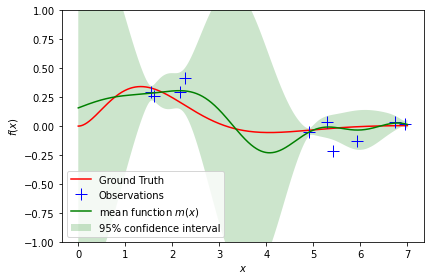

In [200]:
GP = gaussianProcess(ground_truth=gt)
predict_mean, predict_std = GP.predict(gt.domain_grid)

gt.plot_ground_truth()
GP.plot_gaussian_process(predict_mean, predict_std, img_show=True)

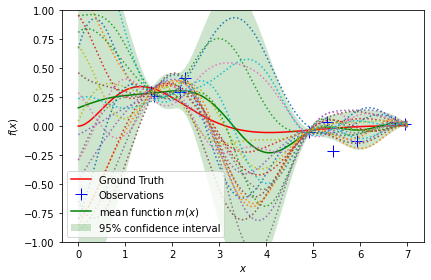

In [201]:
gt.plot_ground_truth()
GP.plot_gaussian_process(predict_mean, predict_std)
GP.plot_trajectories(num_sample=20, img_show=True)